In [1]:
import transformers
from transformers import BertModel, AutoTokenizer, BertTokenizer, PreTrainedTokenizerFast, AdamW, get_linear_schedule_with_warmup, AutoModelForSequenceClassification
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_csv("reviews.csv")

In [3]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else: 
        return 2

df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']

In [4]:
df

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo,0
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo,0
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo,0
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo,0
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15741,Tammy Kay,https://lh3.googleusercontent.com/a-/AOh14GhYP...,I believe that this is by far the best app wit...,5,0,NaN,2018-02-17 06:09:03,NaN,NaN,newest,com.appxy.planner,2
15742,Ysm Johan,https://lh3.googleusercontent.com/a-/AOh14Ggmd...,It sometimes crashes a lot!!,5,0,4.3.7,2018-02-15 10:45:22,NaN,NaN,newest,com.appxy.planner,2
15743,casey dearden,https://lh3.googleusercontent.com/a-/AOh14Gg2U...,Works well for what I need,5,0,4.3.7,2018-02-09 18:40:37,NaN,NaN,newest,com.appxy.planner,2
15744,Jerry G Tamate,https://lh3.googleusercontent.com/a-/AOh14GiTP...,Love it.,5,0,NaN,2018-02-06 12:36:17,NaN,NaN,newest,com.appxy.planner,2


C:\Users\trekc\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


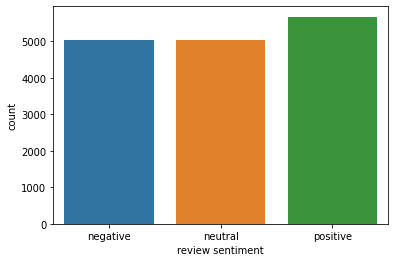

In [5]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [6]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

Я пробовал другие модели, но засоряется видеопамять сильно на большое количество экспериментов в одной тетрадке

In [7]:
from transformers import AutoTokenizer, AutoModel
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
train_labels, val_labels, test_labels = list(df_train.sentiment), list(df_val.sentiment), list(df_test.sentiment)

In [9]:
train_texts, val_texts, test_texts = list(df_train.content), list(df_val.content), list(df_test.content)

In [10]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_token_type_ids=False, max_length=512, return_attention_mask = True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_token_type_ids=False, max_length=512, return_attention_mask = True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_token_type_ids=False, max_length=512, return_attention_mask = True)

In [11]:
class GPReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = GPReviewDataset(train_encodings, train_labels)
val_dataset = GPReviewDataset(val_encodings, val_labels)
test_dataset = GPReviewDataset(test_encodings, test_labels)

In [12]:
batch_ex = next(iter(test_dataset))

### Вроде тут все стандартно, кроме того, что функция потерь считается внутри форварда для трейнера. Взято из примера huggingface на гитхабе

In [13]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_classes = n_classes
  
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None
    ):
        
        last_hidden_state, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        
        output = self.drop(pooled_output)
        logits = self.out(output)
        loss = None
        
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1).to(device))        
        output = (logits,)
        
        return ((loss,) + output) if loss is not None else output 

In [14]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Поставил weighed т.к. у нас три класса

In [15]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Я тестировал на маленьком берте, а потом взял побольше и для сентимент. Так что 3 эпохи для хорошего размера должно хватить. Report_tо для запуска в кеггле

In [16]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    report_to='tensorboard'
)

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics
    # metrics to evaluate
)

trainer.train()

In [18]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'eval_loss': 0.7328177094459534,
 'eval_accuracy': 0.6772554002541296,
 'eval_f1': 0.6753593737235297,
 'eval_precision': 0.6744044015374366,
 'eval_recall': 0.6772554002541296,
 'eval_runtime': 0.597,
 'eval_samples_per_second': 1318.247,
 'eval_steps_per_second': 83.751,
 'epoch': 3.0}

In [19]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'test_loss': 0.7614769339561462,
 'test_accuracy': 0.6535532994923858,
 'test_f1': 0.6500504664640814,
 'test_precision': 0.6476603712188091,
 'test_recall': 0.6535532994923858,
 'test_runtime': 0.564,
 'test_samples_per_second': 1397.177,
 'test_steps_per_second': 88.653,
 'epoch': 3.0}

# Используем cls без линейного слоя

In [20]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

class SentimentClassifierWithCLS(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size*2, n_classes)
        self.n_classes = n_classes
  
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None
    ):
        
        last_hidden_state, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        # первый токен
        cls_token = last_hidden_state[:,0,:]
        output = self.drop(pooled_output)
        concated = torch.cat((cls_token, output), 1)
        logits = self.out(concated)
        loss = None
        
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1).to(device))        
        output = (logits,)
        
        return ((loss,) + output) if loss is not None else output 

In [ ]:
model2 = SentimentClassifierWithCLS(3)

In [ ]:
trainer = Trainer(
    model=model2,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics
    # metrics to evaluate
)

trainer.train()

In [23]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'eval_loss': 0.7105488181114197,
 'eval_accuracy': 0.6759847522236341,
 'eval_f1': 0.6732368633550939,
 'eval_precision': 0.6710300526884346,
 'eval_recall': 0.6759847522236341,
 'eval_runtime': 0.59,
 'eval_samples_per_second': 1333.873,
 'eval_steps_per_second': 84.744,
 'epoch': 3.0}

In [24]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'test_loss': 0.7638748288154602,
 'test_accuracy': 0.6522842639593909,
 'test_f1': 0.6512892393826292,
 'test_precision': 0.6506907623481266,
 'test_recall': 0.6522842639593909,
 'test_runtime': 0.527,
 'test_samples_per_second': 1495.228,
 'test_steps_per_second': 94.875,
 'epoch': 3.0}

# Готовая голова

In [ ]:
model3 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

In [ ]:
trainer = Trainer(
    model=model3,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics
    # metrics to evaluate
)

trainer.train()

In [27]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'eval_loss': 0.7211514711380005,
 'eval_accuracy': 0.6797966963151207,
 'eval_f1': 0.6763525261072895,
 'eval_precision': 0.6739233099914501,
 'eval_recall': 0.6797966963151207,
 'eval_runtime': 0.59,
 'eval_samples_per_second': 1333.904,
 'eval_steps_per_second': 84.746,
 'epoch': 3.0}

In [28]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'test_loss': 0.7639667391777039,
 'test_accuracy': 0.6560913705583756,
 'test_f1': 0.6558807551441604,
 'test_precision': 0.6558277666729361,
 'test_recall': 0.6560913705583756,
 'test_runtime': 0.549,
 'test_samples_per_second': 1435.358,
 'test_steps_per_second': 91.076,
 'epoch': 3.0}

# CLS на нескольких слоях

#### Я соединю вектора и передам получившуюся длину в линейный слой. Беру все слои, т.к. их мало в этой модели

In [29]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

class SentimentClassifierWithMultipleCLS(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size*self.bert.config.num_hidden_layers, n_classes)
        self.n_classes = n_classes
  
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None
    ):
        
        last_hidden_state, pooled_output, hidden_states = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False,
          output_hidden_states=True
        )

        concated = None
        for state in hidden_states[1:]:
            cls_token = state[:,0,:]
            if concated is not None:
                concated = torch.cat((cls_token, concated), 1)
            else:
                concated = cls_token
        logits = self.out(concated)
        loss = None
        
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1).to(device))        
        output = (logits,)
        
        return ((loss,) + output) if loss is not None else output 

In [ ]:
model4 = SentimentClassifierWithMultipleCLS(3)

In [31]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    report_to='tensorboard'
)

PyTorch: setting up devices


In [ ]:
trainer = Trainer(
    model=model4,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics
    # metrics to evaluate
)

trainer.train()

In [34]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 8


{'eval_loss': 0.6870954632759094,
 'eval_accuracy': 0.6886912325285895,
 'eval_f1': 0.6866677875672879,
 'eval_precision': 0.6850072224524625,
 'eval_recall': 0.6886912325285895,
 'eval_runtime': 0.843,
 'eval_samples_per_second': 933.568,
 'eval_steps_per_second': 117.437,
 'epoch': 3.0}

In [35]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 8


{'test_loss': 0.7551164031028748,
 'test_accuracy': 0.6738578680203046,
 'test_f1': 0.6722752200995469,
 'test_precision': 0.6709353384498287,
 'test_recall': 0.6738578680203046,
 'test_runtime': 0.946,
 'test_samples_per_second': 832.981,
 'test_steps_per_second': 104.651,
 'epoch': 3.0}

### Выше я конкатенировал векторы, теперь попробую взять среднее по всем

In [36]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

class SentimentClassifierWithMultipleCLS2(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_classes = n_classes
  
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None
    ):
        
        last_hidden_state, pooled_output, hidden_states = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False,
          output_hidden_states=True
        )

        all_hidden_states = torch.stack(hidden_states)
        cls_embs = torch.mean(all_hidden_states[:, :, 0], 0)
        
        logits = self.out(cls_embs)
        loss = None
        
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1).to(device))        
        output = (logits,)
        
        return ((loss,) + output) if loss is not None else output 

In [ ]:
model5 = SentimentClassifierWithMultipleCLS2(3)

In [ ]:
trainer = Trainer(
    model=model5,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics
    # metrics to evaluate
)

trainer.train()

In [39]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 8


{'eval_loss': 0.6973204016685486,
 'eval_accuracy': 0.6886912325285895,
 'eval_f1': 0.6891410200339234,
 'eval_precision': 0.6897203868816901,
 'eval_recall': 0.6886912325285895,
 'eval_runtime': 0.905,
 'eval_samples_per_second': 869.614,
 'eval_steps_per_second': 109.392,
 'epoch': 3.0}

In [40]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 8


{'test_loss': 0.7470071911811829,
 'test_accuracy': 0.6649746192893401,
 'test_f1': 0.6654510922345329,
 'test_precision': 0.6662305137654405,
 'test_recall': 0.6649746192893401,
 'test_runtime': 0.88,
 'test_samples_per_second': 895.444,
 'test_steps_per_second': 112.499,
 'epoch': 3.0}

# Тест на отзывах<br>
Беру лучшую модель

In [41]:
twostar = """Why react isn't registering fast, I liked something and then scroll down, After sometime I saw the post and my reaction wasn't there. Not one time, this happens everytime. Don't blame the internet, it's pretty fast here.Fix the problem , otherwise I'm gonna decrease my rating even more."""

In [42]:
fivestar = """Hi I really love this app cause it's light on storage, less data consumption but you said it work in any network condition ahh. No it's not working on any network condition even in 4G network still slow. And this issue I encounter is so annoying . When I'm watching videos and when I'm at the best moment or best scene of the video it kicks me out of the app and automatically back to start where I open the app and I can't find the video so please fix this issue 😊"""

In [43]:
threestar = """Hi, good evening. I have a challenge. I've been trying to update my profile, and upload my stories but it's not working. And whenever i tried to do so, it automatically exits. Please help me out. Thanks, though your app is amazing, but i think there should be more features like . Been able to change my color, just the way I can switch to night mode."""

In [44]:
from torch.nn.functional import softmax

def get_sent(sentence, model):
    encoding = tokenizer.encode_plus(
      sentence,
      max_length=512,
      add_special_tokens=True, 
      return_token_type_ids=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',  
      truncation=True
    ).to(device)
    
    return softmax(model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])[0], dim=1)

In [53]:
get_sent(twostar, model5)

tensor([[0.7212, 0.2438, 0.0350]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [54]:
get_sent(threestar, model5)

tensor([[0.0621, 0.5885, 0.3494]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [55]:
get_sent(fivestar, model5)

tensor([[0.1248, 0.6934, 0.1818]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Результаты вполне норм для маленькой модели и 3 эпох (средние отзывы угадал!). Но мб примеры сложные.

In [56]:
fivestar_2 = """Great experience when one uses the face life app. It's the best of the season. We encourage everyone to share it with friends and family as well as with the different social media groups. Its good for business, social activities, relationships, friends search, research, marketing, learning new ideas. This is a global market for the season. It's free for people with open minded ideas about life ideas. It's an opportunity for jobs and creativity. It's a meeting place for tourists and visiting"""

In [57]:
get_sent(fivestar_2, model5)

tensor([[0.0183, 0.0318, 0.9499]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Другое дело. Попробую еще простые примеры от себя

In [58]:
get_sent('this app is so not good but not bad', model5)

tensor([[0.6181, 0.3491, 0.0328]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [61]:
get_sent('this app is not so good', model5)

tensor([[0.4947, 0.4514, 0.0538]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [60]:
get_sent('this app is so good', model5)

tensor([[0.0263, 0.2147, 0.7590]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Я предполагаю, что бОльшая модель может помочь (или большее количество эпох). Манипуляции с выходами помогло поднять результаты, особенно среднее по слоям. Для других моделей возможно будут другие результаты)